<a href="https://colab.research.google.com/github/steffen-mdv/meep_lens/blob/main/meep_dipole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Colab Notebook to run FDTD simulations with meep

Author: Steffen Michaelis de Vasconcellos

## 0. Installation
First, we install CondaLab via pip to have the convenient Conda environment. It takes about 30-60 seconds. The session will send a message that it has crashed - this is normal. The environment is deleted each time you reconnect to Google Colab, so keep the runtime open.


In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  try:
    import condacolab
    condacolab.check()
  except ImportError:
    !pip install -q condacolab
    import condacolab
    condacolab.install()


✨🍰✨ Everything looks OK!


Then we install meep via anaconda. We don't want to see the output therefore we use %%capture. Takes about 1 or 2 minutes.

In [ ]:
%%capture
try:
  import meep as matplotlib
except ImportError:
  !conda install -c conda-forge pymeep

# Meep simulation

Now we can run a meep simulation. The meep documentation is found here: https://meep.readthedocs.io/en/latest/Python_User_Interface/

## 1. Import packages



In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

## 2. Define constants
Define some physical constants of the simulation (e.g. refractive index, wavelength) and some parameters of the FDTD simulation (e.g. resolution, size of the simulation grid)

Most important: Defines the position and the polarization of the dipole source. Here you can change things!

In [ ]:
#refractive indieces
index_substrate = 1.476
index_air = 1

#dipole orientation "s" or "p" or "z" or "45°"
source_direction = "z"

#dipole hight above the substrate in um
source_position = 0.2

#wavelength in um
wavelength = 0.625


## Calculate and define some further constants for the simulation - don't edit unless you know what you are doing

#frequency
fcen = 1/wavelength
df = 0.4

#resolution
resolution = 64

#resolution is set via parameters alternative here:
#resolution_per_wavelength = 8
#resolution = int(np.floor(resolution_per_wavelength*fcen*index_lens))  # pixels/um
print("Resolution", resolution)

dpml = 0.5

#defince simulation cell size.
sx = 4  #size of simulation area
sy = 4

substrate_height = sy/2 + dpml
substrate_x = sx + 2*dpml


Resolution 64


## 3. Define the geometry in meep
Here one half of the simulation space is filled with the substrate, the other one is set to air.

In [ ]:
#define geometry
geometry = []


#air
geometry.append(
    mp.Block(
        size=mp.Vector3(sx+2*dpml, sy+2*dpml, 0),
        center=mp.Vector3(0,substrate_height/2,0),
        material=mp.Medium(index=index_air)))


#substrate
geometry.append(
    mp.Block(
        size=mp.Vector3(substrate_x, substrate_height, 0),
        center=mp.Vector3(0,-substrate_height/2,0),
        material=mp.Medium(index=index_substrate)))


## 4. Define the dipole source in meep
Don't edit here.

In [ ]:
if source_direction == "p":
    print("Source direction Ex")
    src_cmpt = mp.Ex
elif source_direction == "s":
    print("Source direction Ez")
    src_cmpt = mp.Ez
elif source_direction == "z":
    print("Source direction perpendicular to surface (Ey)")
    src_cmpt = mp.Ey

sources = [mp.Source(src=mp.GaussianSource(fcen,fwidth=df),
                     center=mp.Vector3(0,source_position,0),
                     component=src_cmpt)]

Source direction perpendicular to surface (Ey)


## 5. Setup the simulation
Don't edit here. Running this cell resets also the simulation.

In [ ]:
#calculate cell
cell = mp.Vector3(sx+2*dpml,sy+2*dpml)  #size of computation cell

#make PML
pml_layers = [mp.PML(dpml)]

#add symmetries
#in a 2D simulation (optical axis in Y direction), we have only symmetires in X direction. This can be either inverted (phase=-1) or normal.
if src_cmpt == mp.Ex:
    symmetries = [mp.Mirror(mp.X,phase=-1)]
elif src_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X,phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X,phase=+1)]

#make simulation
sim = mp.Simulation(cell_size=cell,
                    resolution=resolution,
                    sources=sources,
                    geometry=geometry,
                    symmetries=symmetries,
                    boundary_layers=pml_layers,
                    force_complex_fields=False)

nearfield_box_up = sim.add_near2far(fcen, 0, 1,
                                 mp.Near2FarRegion(center=mp.Vector3(0,sy/2),
                                                   size=mp.Vector3(sx,0)),
                                 mp.Near2FarRegion(center=mp.Vector3(sx/2,sy/4),
                                                   size=mp.Vector3(0,sy/2)),
                                 mp.Near2FarRegion(center=mp.Vector3(-sx/2,sy/4),
                                                   size=mp.Vector3(0,sy/2),
                                                  weight=-1),
                                 #mp.Near2FarRegion(center=mp.Vector3(0,+1/resolution),
                                  #                size=mp.Vector3(sx,0),
                                   #               weight=-1)
                                 )

nearfield_box_down = sim.add_near2far(fcen, 0, 1,
                                 mp.Near2FarRegion(center=mp.Vector3(0,-sy/2),
                                                   size=mp.Vector3(sx,0),
                                                   weight=-1),
                                 mp.Near2FarRegion(center=mp.Vector3(sx/2,-sy/4),
                                                   size=mp.Vector3(0,sy/2)),
                                 mp.Near2FarRegion(center=mp.Vector3(-sx/2,-sy/4),
                                                   size=mp.Vector3(0,sy/2),
                                                  weight=-1),
                                 #mp.Near2FarRegion(center=mp.Vector3(0,-1/resolution),
                                 #                 size=mp.Vector3(sx,0))
                                 )


flux_box = sim.add_flux(fcen, 0, 1,
                        mp.FluxRegion(center=mp.Vector3(0,+0.5*sy),
                                      size=mp.Vector3(sx,0)),
                        mp.FluxRegion(center=mp.Vector3(0,-0.5*sy),
                                      size=mp.Vector3(sx,0),
                                      weight=-1),
                        mp.FluxRegion(center=mp.Vector3(+0.5*sx,0),
                                      size=mp.Vector3(0,sy)),
                        mp.FluxRegion(center=mp.Vector3(-0.5*sx,0),
                                      size=mp.Vector3(0,sy),
                                      weight=-1))


## 6. Run the simulation
Running for a certain amount of timesteps (e.g. 100). You can run this cell multiple times to continoue the simulation. `until` means that that number of step is added to the simulation. The number of timesteps required that the light propagates through the whole cell depends on the size of the cell and the resolution

In [ ]:
run_until = 10
sim.run(until=run_until)

-----------
Initializing structure...
Halving computational cell along direction x
time for choose_chunkdivision = 0.00671697 s
Working in 2D dimensions.
Computational cell is 5 x 5 x 0 with resolution 64
     block, center = (0,1.25,0)
          size (5,5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-1.25,0)
          size (5,2.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.17858,2.17858,2.17858)
time for set_epsilon = 0.153848 s
-----------


FloatProgress(value=0.0, description='0% done ', max=10.0)

run 0 finished at t = 10.0 (1280 timesteps)


## 7. Analyze

After running the simulation, we can analyze the output. Here we plot the total power of the electric field overlayed with epsilon.

Edit vmax if the color scale is not appropriate.

You can also plot other parameters, e.g. the electric field. Try uncommenting the lines.

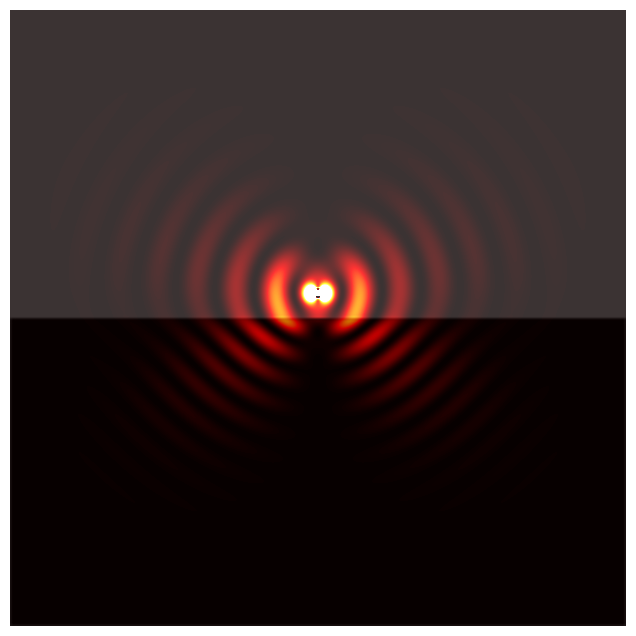

In [ ]:
eps_data = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Dielectric).transpose()
#efield_data = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=src_cmpt).transpose()
tot_pwr = sim.get_tot_pwr().transpose()

plt.figure(figsize=(10,8))
plt.imshow(np.flip(eps_data), interpolation='spline36', cmap='binary')
plt.imshow(np.flip(tot_pwr), interpolation='spline36', cmap='hot', vmin=0,vmax=.5,alpha=0.8)
#plt.imshow(efield_data, interpolation='spline36', cmap='RdBu', vmin=-.2,vmax=.2,alpha=0.8)
plt.axis('off')
plt.show()

# 8. Run further for far field
Runs the simulation until the field is decayed

In [ ]:
sim.run(until_after_sources=mp.stop_when_dft_decayed())

on time step 1280 (time=10), 0.00403933 s/step
run 1 finished at t = 25.0 (3200 timesteps)


# 9. Get the flux

In [ ]:
near_flux = mp.get_fluxes(flux_box)[0]

# half side length of far-field square box OR radius of far-field circle
r = 1000/fcen

# resolution of far fields (points/μm)
res_ff = 1

far_flux_box_up = (nearfield_box_up.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] -
                nearfield_box_up.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=-r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] +
                nearfield_box_up.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0] -
                nearfield_box_up.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(-r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0])


far_flux_box_down = (nearfield_box_down.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] -
                nearfield_box_down.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=-r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] +
                nearfield_box_down.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0] -
                nearfield_box_down.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(-r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0])

# 10. Calculate the radiation pattern

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


flux (up):, 1.920470, 0.792029, 0.791579
flux (down):, 1.920470, 1.135252, 1.133260
flux:, 1.920470, 1.927281, 1.924839


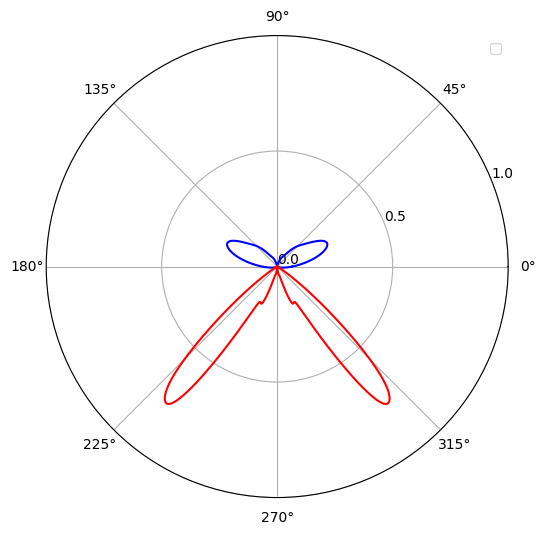

In [ ]:
npts = 1000  # number of points in [0,2*pi) range of angles
angles = 2*math.pi/npts*np.arange(npts)

E_up = np.zeros((npts,3),dtype=np.complex128)
H_up = np.zeros((npts,3),dtype=np.complex128)
E_down = np.zeros((npts,3),dtype=np.complex128)
H_down = np.zeros((npts,3),dtype=np.complex128)
for n in range(npts):
    ff = sim.get_farfield(nearfield_box_up,
                          mp.Vector3(r*math.cos(angles[n]),
                                     r*math.sin(angles[n])))
    E_up[n,:] = [ff[j] for j in range(3)]
    H_up[n,:] = [ff[j+3] for j in range(3)]
    ff = sim.get_farfield(nearfield_box_down,
                          mp.Vector3(r*math.cos(angles[n]),
                                     r*math.sin(angles[n])))
    E_down[n,:] = [ff[j] for j in range(3)]
    H_down[n,:] = [ff[j+3] for j in range(3)]

Px_up = np.real(np.conj(E_up[:, 1]) * H_up[:, 2] - np.conj(E_up[:, 2]) * H_up[:, 1])
Py_up = np.real(np.conj(E_up[:, 2]) * H_up[:, 0] - np.conj(E_up[:, 0]) * H_up[:, 2])
Pr_up = np.sqrt(np.square(Px_up) + np.square(Py_up))

Px_down = np.real(np.conj(E_down[:, 1]) * H_down[:, 2] - np.conj(E_down[:, 2]) * H_down[:, 1])
Py_down = np.real(np.conj(E_down[:, 2]) * H_down[:, 0] - np.conj(E_down[:, 0]) * H_down[:, 2])
Pr_down = np.sqrt(np.square(Px_down) + np.square(Py_down))

# integrate the radial flux over the circle circumference
far_flux_circle_up = np.sum(Pr_up)*2*np.pi*r/len(Pr_up)
far_flux_circle_down = np.sum(Pr_down)*2*np.pi*r/len(Pr_down)

print("flux (up):, {:.6f}, {:.6f}, {:.6f}".format(near_flux,far_flux_box_up,far_flux_circle_up))
print("flux (down):, {:.6f}, {:.6f}, {:.6f}".format(near_flux,far_flux_box_down,far_flux_circle_down))
print("flux:, {:.6f}, {:.6f}, {:.6f}".format(near_flux,far_flux_box_down+far_flux_box_up,far_flux_circle_down+far_flux_circle_up))

# Analytic formulas for the radiation pattern as the Poynting vector
# of an electric dipole in vacuum. From Section 4.2 "Infinitesimal Dipole"
# of Antenna Theory: Analysis and Design, 4th Edition (2016) by C. Balanis.
if src_cmpt == mp.Ex:
    flux_theory = np.sin(angles) ** 2
elif src_cmpt == mp.Ey:
    flux_theory = np.cos(angles) ** 2
elif src_cmpt == mp.Ez:
    flux_theory = np.ones((npts,))

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 6))
ax.plot(angles,Pr_up/(max(Pr_up)+max(Pr_down)),'b-')
ax.plot(angles,Pr_down/(max(Pr_up)+max(Pr_down)),'r-')
ax.set_rmax(1)
ax.set_rticks([0,0.5,1])
ax.grid(True)
ax.set_rlabel_position(22)
ax.legend()

if mp.am_master():
    fig.savefig(
        f"radiation_pattern_{mp.component_name(src_cmpt)}.png",
        dpi=150,
        bbox_inches="tight",
    )